In [1]:
# Python 3.9. Anaconda recommended.
# -- Prerequisites install 
#%pip install ipykernel --user
#%pip install stable_baselines3 --user
#%pip install tensorboard --user
#%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


# STABLEBASELINES TESTBED

In [1]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools
import math

from datetime import datetime


import sys
sys.path.append('../../battery-modeling/Step 3. Simulation')

import sys
sys.path.append('../../battery-modeling/Step 3. Simulation')

import SimCellPack as scp



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, numCells, simCycles, sampleFactor, utilization, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1

      self.numCells = numCells

      # Define cell model simualtor 
      self.cellModel = scp.SimCellPack(numCells = numCells, simCycles = simCycles, sampleFactor = sampleFactor, utilization=utilization)
      self.cellModel.startSim()

   
      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.numCells,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.numCells,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."

      # Scale the action space between 0 and 1
      battery_current_values = get_converted_action(action)

      # Send the action as feedback to the cell model
      self.cellModel.sendSimFeedback(battery_current_values)

      # Flags for determining certain occurences
      terminated = False
      truncated = False

      # Save state before action
      initial_state = self.state

      #Apply action to state
      code, self.state = self.cellModel.getSimStep()

      #print("Step: state: " + str(self.state) + " code: " + str(code))

      # Cell simulation finished, terminate
      if code == 0.0:
         truncated = True

      # Compute reward and termination cases
      # Apply step reward. Continue running.
      reward = compute_ballancing_reward(self.state, initial_state, battery_current_values, True)

      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}

   def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None,):
   # Reset runs first before starting the simulation to get the initial states
        
      super().reset(seed=seed)

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("!-- RESETTED AT : ", current_time)

      # Stops and restarts the cell simulation
      self.cellModel.resetSim()

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("DONE RESETTING: ", current_time)


      self.episode_time = 0

      # Get initial states from the cell model
      code, self.state = self.cellModel.getSimStep()

      #print("Reset state: " + str(self.state))

      return np.array(self.state, dtype=np.float32), {}
   

   def __del__(self):
      self.cellModel.stopSim()



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0))/2  #from [-1, 1] to [0, 1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff), or (mean_diff*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.02, 0.05, 0, 0.01, 0.1]
numbers = [0.8268956, 0.7947008, 0.8274856]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation

# Get reward for a given step
def compute_ballancing_reward(initial_socs, action_socs, action, should_print):

   # ---- REWARD ALTERNATIVES ----

   # 1. Cost as distance between 2 numbers. Yang
   #reward = -pow(soc0 - soc1, 2)
      
   # 2. Cost as standard deviation
   # reward = -np.std(socs, dtype=np.float32)

   # ---- REWARD ALTERNATIVES ----




   # normalized_socs = []
   # for soc in socs:
   #    newsoc = (soc - min(socs)) / (max(socs) - min(socs))
   #    normalized_socs.append(newsoc)
   
   # SOCs are now between [0, 1]


    reward = 0

    initial_min_soc = min(initial_socs)
    action_min_soc = min(action_socs)
    if (should_print):
      print("MIN SOC :  " + str(initial_min_soc))
    index_min_soc = initial_socs.index(min(initial_socs))

   # reduce reward for any actions on the minimum SOC
    if action[index_min_soc] != 0.0:
        # reward -= 0.01
        # reward = -action[index_min_soc]
        reward = -20
   
   # else:
      # give 0.01 for each SOC that is within 0.01 distance of the smallest SOC.
      # non_min_soc_indexes = list(range(len(socs)))
      # non_min_soc_indexes.remove(index_min_soc)

      # for i in non_min_soc_indexes:
      #    if (math.isclose(min(socs), socs[i], abs_tol=0.001)):
      #       # reward += 0.01
      #      reward += 1

      
   # Introduce closeness to the reward. Penalty = abs ( maxsoc - minsoc )
   # reward = reward - compute_closeness(socs_after_action)*100
    else:
      # initial_without_min = initial_socs
      # initial_without_min.remove(initial_min_soc)

        for soc_index in range(0, len(initial_socs)):
            if soc_index != index_min_soc:         
                initial_diff_to_min = initial_socs[soc_index] - initial_min_soc
                action_diff_to_min = action_socs[soc_index] - action_min_soc
            
                if (should_print):
                    print(initial_socs[soc_index])
                    print(action_socs[soc_index])
                    print("Initial diff :  " + str(initial_diff_to_min))
                    print("Action diff :  " + str(action_diff_to_min))
                    print ("----------")


                if math.isclose(action_diff_to_min, 0, abs_tol=0.02) and action[soc_index] != 0.0:
                    # if an soc is BALANCED with the min_soc with intervention, we reward it
                    reward += 20
                elif math.isclose(action_diff_to_min, 0, abs_tol=0.02) and action[soc_index] == 0.0:
                    # if an soc is BALANCED with min_soc without intervention, we don't reward it
                    reward += 0
                elif (action_diff_to_min < initial_diff_to_min) and action_diff_to_min > 0 and action[soc_index] != 0.0:
                    # if an soc is approaching the min_soc with intervention, we reward it
                    reward += 10
                elif (action_diff_to_min < initial_diff_to_min) and action_diff_to_min > 0 and action[soc_index] == 0.0:
                    # if an soc is approaching the min_soc without intervention, we don't reward it
                    reward += 0
                else:
                    reward -= 5

    return reward


print("-----------")
# print(compute_ballancing_reward([0.56971985, 0.55291414, 0.55013263], [0.56971985, 0.55291414, 0.55013263], [0.0, 0.5, 0.8], False))
# print(compute_ballancing_reward([0.36923957, 0.3938384, 0.40389347], [0.0, 0.0, 0.0], False))
# print(compute_ballancing_reward([0.8429049, 0.8430514, 0.8428894], [0., 0., 0.], False))
# print(compute_ballancing_reward([0.8429049, 0.8390514, 0.8428894], [0., 0., 0.], False))
# print(compute_ballancing_reward([0.7342201, 0.7251791, 0.7474329], [0., 0., 0.], False))
print(compute_ballancing_reward([0.7555555, 0.7155555, 0.7555555], [0.7055555, 0.7055555, 0.7555555], [0.4, 0., 0.], True))
print(compute_ballancing_reward([0.7555555, 0.7155555, 0.7555555], [0.7155555, 0.7155555, 0.7155555], [0.0, 0., 0.], True))




0.03278480000000006
0.0153177325
-----------
MIN SOC :  0.7155555
0.7555555
0.7055555
Initial diff :  0.040000000000000036
Action diff :  0.0
----------
0.7555555
0.7555555
Initial diff :  0.040000000000000036
Action diff :  0.050000000000000044
----------
15
MIN SOC :  0.7155555
0.7555555
0.7155555
Initial diff :  0.040000000000000036
Action diff :  0.0
----------
0.7555555
0.7155555
Initial diff :  0.040000000000000036
Action diff :  0.0
----------
0


In [1]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools
import math

from datetime import datetime


import sys
sys.path.append('../../battery-modeling/Step 3. Simulation')

import sys
sys.path.append('../../battery-modeling/Step 3. Simulation')

import SimCellPack as scp



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, numCells, simCycles, sampleFactor, utilization, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1

      self.numCells = numCells

      # Define cell model simualtor 
      self.cellModel = scp.SimCellPack(numCells = numCells, simCycles = simCycles, sampleFactor = sampleFactor, utilization=utilization)
      self.cellModel.startSim()

   
      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.numCells,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.numCells,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."

      # Scale the action space between 0 and 1
      battery_current_values = get_converted_action(action)

      # Send the action as feedback to the cell model
      self.cellModel.sendSimFeedback(battery_current_values)

      # Flags for determining certain occurences
      terminated = False
      truncated = False

      # Save state before action
      initial_state = self.state

      #Apply action to state
      code, self.state = self.cellModel.getSimStep()

      #print("Step: state: " + str(self.state) + " code: " + str(code))

      # Cell simulation finished, terminate
      if code == 0.0:
         truncated = True

      # Compute reward and termination cases
      # Apply step reward. Continue running.
      reward = compute_ballancing_reward(self.state, initial_state, battery_current_values, False)

      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}

   def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None,):
   # Reset runs first before starting the simulation to get the initial states
        
      super().reset(seed=seed)

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("!-- RESTARTED AT : ", current_time)

      # Stops and restarts the cell simulation
      self.cellModel.resetSim()

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("DONE RESTARTING: ", current_time)


      self.episode_time = 0

      # Get initial states from the cell model
      code, self.state = self.cellModel.getSimStep()

      #print("Reset state: " + str(self.state))

      return np.array(self.state, dtype=np.float32), {}
   

   def __del__(self):
      self.cellModel.stopSim()



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0))/2  #from [-1, 1] to [0, 1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff), or (mean_diff*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.02, 0.05, 0, 0.01, 0.1]
numbers = [0.8268956, 0.7947008, 0.8274856]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation

# Get reward for a given step
def compute_ballancing_reward(socs_after_action, initial_socs, action, should_print):

   # ---- REWARD ALTERNATIVES ----

   # 1. Cost as distance between 2 numbers. Yang
   #reward = -pow(soc0 - soc1, 2)
      
   # 2. Cost as standard deviation
   # reward = -np.std(socs, dtype=np.float32)

   # ---- REWARD ALTERNATIVES ----




   # normalized_socs = []
   # for soc in socs:
   #    newsoc = (soc - min(socs)) / (max(socs) - min(socs))
   #    normalized_socs.append(newsoc)
   
   # SOCs are now between [0, 1]


   reward = 0

   index_min_soc = initial_socs.index(min(initial_socs))

   # reduce reward for any actions on the minimum SOC
   if action[index_min_soc] != 0.0:
      # reward -= 0.01
      # reward = -action[index_min_soc]
      reward = -10
   
   else:
      if compute_closeness(socs_after_action) < compute_closeness(initial_socs) and compute_closeness(socs_after_action) > 0:
         reward = 5
      # elif compute_closeness(socs_after_action) < 0:
      #    reward = -5

      # give 0.01 for each SOC that is within 0.01 distance of the smallest SOC.
      # non_min_soc_indexes = list(range(len(socs)))
      # non_min_soc_indexes.remove(index_min_soc)

      # for i in non_min_soc_indexes:
      #    if (math.isclose(min(socs), socs[i], abs_tol=0.001)):
      #       # reward += 0.01
      #       reward += 1

      
   # Introduce closeness to the reward. Penalty = abs ( maxsoc - minsoc )
   # reward = reward - compute_closeness(socs_after_action)*100

   # introduce exponential reward? the farther the SOCs get, cost increases exponentially
             
   return reward


print("-----------")
# print(compute_ballancing_reward([0.56971985, 0.55291414, 0.55013263], [0.0, 0.5, 0.8], False))
# print(compute_ballancing_reward([0.36923957, 0.3938384, 0.40389347], [0.0, 0.0, 0.0], False))
# print(compute_ballancing_reward([0.8429049, 0.8430514, 0.8428894], [0., 0., 0.], False))
# print(compute_ballancing_reward([0.8429049, 0.8390514, 0.8428894], [0., 0., 0.], False))
# print(compute_ballancing_reward([0.7342201, 0.7251791, 0.7474329], [0., 0., 0.], False))
print(compute_ballancing_reward([0.6455555, 0.7055555, 0.7355555], [0.7555555, 0.7055555, 0.7555555], [0., 0., 0.], False))



0.03278480000000006
0.0153177325
-----------
0


# PLOTTING FUNCTIONS:

In [2]:
print(compute_ballancing_reward([0.56971985, 0.55291414, 0.55013263], [0.0, 0.5, 0.0], False))
print(compute_ballancing_reward([0.36923957, 0.3938384, 0.40389347], [0.0, 0.0, 0.0], False))
print(compute_ballancing_reward([0.8429049, 0.8430514, 0.8428894], [0., 0., 0.], False))
print(compute_ballancing_reward([0.7342201, 0.7251791, 0.7474329], [0., 0., 0.], False))

-1.9587220000000016
-3.4653899999999958
-0.016199999999999548
-2.225379999999999


In [2]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=1)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())

# plot_results(log_dir)


In [3]:
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import os
import torch
import numpy as np
from typing import Optional, Union




class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(self.log_dir)

        return True
    
    



# Initialize environment

In [4]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env


# Create log dir
log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)


# Create and wrap the environment
env = BatteryEnv(numCells = 3, simCycles = 15, sampleFactor = 30, utilization=0.80, render_mode = False)

#for i in range(0, 100):
#    check_env(env)


# Logs will be saved in log_dir/monitor.csv 
env = Monitor(env, log_dir) #monitor for raw environments





# Opt1: Initialize a new model

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3


print("Is CUDA enabled?", torch.cuda.is_available())

# PPO 118
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.0009, n_epochs=5, batch_size=128)

# ppo 122
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0009, n_steps=2048*4, n_epochs=5, batch_size=32)

# ppo 123 - bad
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0009, n_steps=2048*2, n_epochs=5, batch_size=16)

# ppo 125 - bad - high learning rate makes training unstable
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0015, n_steps=1024, n_epochs=10, batch_size=256)

# ppo 126 - promising, sort of unstable, better eval results than default, also runs faster
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024, n_epochs=10, batch_size=256)

# ppo128
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=2048, n_epochs=10, batch_size=256*2)

# ppo129 - decent, worse than 126
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=2048, n_epochs=10, batch_size=256*4)

# ppo130
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024*4, n_epochs=10, batch_size=1024*4)

# ppo131 good
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024*16, n_epochs=10, batch_size=1024*4)

# ppo132
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024*16*3, n_epochs=10, batch_size=1024*4*3)

# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/",  
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024, n_epochs=10, batch_size=256, gamma=0.80)



# DEFAULT MODEL, DEFAULT HYPERPARAMETERS. Stable:  ppo_124
model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", learning_rate=0.0006)



Is CUDA enabled? True
Using cuda device
Wrapping the env in a DummyVecEnv.


# Opt 2: Load existing trained model from save file

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3

model = PPO.load(env=env, path=os.path.join(log_dir, "best_model_ppo_batterysim_50000b"))

Wrapping the env in a DummyVecEnv.


Train model for X timesteps.
Can be interrupted and retain training.

In [6]:
# Eval callback, for plotting and seeing how the training is going, and saving best models. No effect on the results.
# We instantiate the callback only once so on if we keep training the model in future runs, it remember the 'best model' and saves accordingly

# Runs 1 simulation for evaluation every 50000 steps (average episode length ~14000 (!!! this varies a lot based on sample times), so every 5 episodes of training we run 1 eval episode)
# 1 episode = 1 full run of the matlab simulation
callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 1, eval_freq= 100000,
                            best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"))


# For callback with plot, add this parameter to the EvalCallback:       callback_on_new_best=PlotResultsCallback(log_dir=log_dir))

In [7]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


# Run training cycles on the model. (range(0, x))
# Can just be 1 training cycle of many steps, or multiple cycles of fewer steps. 
# Training results are similar as long as it gets to do at least a few episodes within a cycle.

# Around 1 mil steps it should not perform worse than a nonbalancing run (runs with no action from the RL model).
# Nonbalancing runs give around -30000 -35000 total reward for 1 episode
for i in range (0, 1):
    # model.learn(total_timesteps=int(300000), callback=callback)
    model.learn(total_timesteps=int(300000000000), callback=callback)



#LOG PRINTS INFO:
    
# rollout/                             
#    ep_len_mean          1.34e+04     
#    ep_rew_mean         -1.33e+05   
#    Episoed average length and (total) reward for the last 3 episodes. Can be changed in 

# Plot helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


# !!!!!!!!!! PPO1 and TRPO update self.num_timesteps after each rollout (and not each step) because they rely on MPI.
# so you might see discrepencies betwen timesteps in the prints

!-- RESTARTED AT :  12:00:56
DONE RESTARTING:  12:00:56
Logging to ./pponorm_tensorboard_log/PPO_141
-----------------------------
| time/              |      |
|    fps             | 282  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
!-- RESTARTED AT :  12:01:13
DONE RESTARTING:  12:01:13
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.03e+03    |
|    ep_rew_mean          | -3.02e+04   |
| time/                   |             |
|    fps                  | 226         |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017217612 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.29       |
|    explained_variance   | -2.03e-06   |
|  

KeyboardInterrupt: 

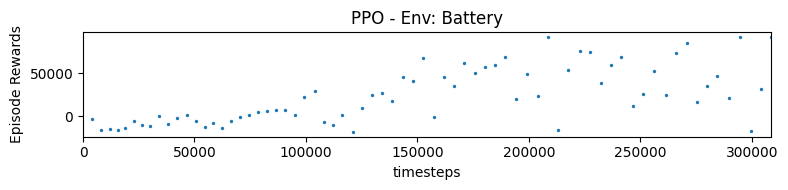

In [42]:

results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

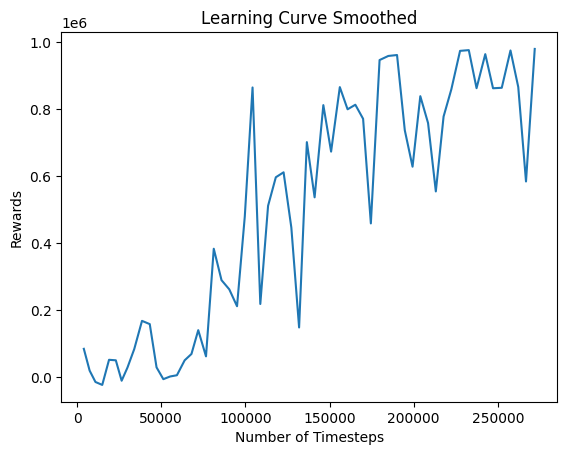

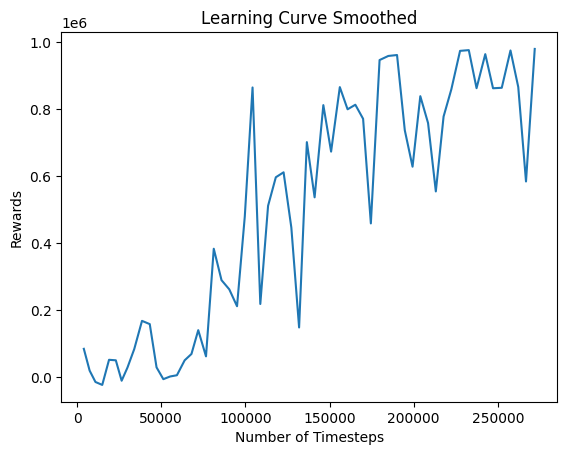

In [55]:

plot_results(log_dir)

# Test 1 episode of the model

In [43]:
model.save(os.path.join(log_dir, "best_model_ppo_batterysim_r"))

!-- RESTARTED AT :  12:28:14
DONE RESTARTING:  12:28:14
[5.]
[[0.48019108 0.474041   0.47732458]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48018476 0.47403482 0.47731796]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48017848 0.47402865 0.4773113 ]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48017216 0.47402248 0.4773047 ]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48016587 0.4740163  0.47729808]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48015955 0.4740101  0.47729146]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48015326 0.47400394 0.47728482]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48014694 0.47399777 0.4772782 ]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48014066 0.4739916  0.4772716 ]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48013434 0.47398543 0.47726497]]  ACTION:[0. 0. 0.]  >>>>    REWARD:  [5.]   
[5.]
[[0.48012805 0.47397926 0.47725832]]  ACTION:[0. 0. 0.]  >>>>    REWA

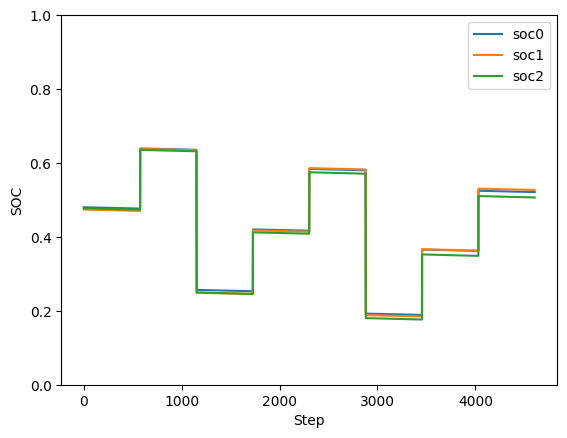

In [9]:
from stable_baselines3 import A2C, SAC, PPO, TD3
import os

# model.save(os.path.join(log_dir, "best_model_ppo_batterysimm"))

# eval_env = BatteryEnv(numCells = 3, simCycles = 2, sampleFactor = 10, render_mode = False)
# model = PPO.load(env=eval_env, path=os.path.join(log_dir, "best_model_ppo_batterysim"))

# def test_trained_model():
obs = model.get_env().reset()
episode_reward = 0

obsArray = []

while True:
    obsArray.append(obs)
    action, _states = model.predict(obs)
    # oldObs = obs
    obs, rewards, done, info = model.get_env().step(action)
    print(rewards)
    episode_reward += rewards.squeeze()

    if not done:
        for ac in get_converted_action(action.flatten()):
            if ac != 0:
                print("NON-ZERO!")
        print(str(obs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
    else:
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(str(get_converted_action(action.flatten()))))
        print("REWARD:  " + str(rewards[0]))
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # plot final model
        fig = plt.figure(1)

        data_np = np.array(obsArray)

        plt.xlabel('Step')
        plt.ylabel('SOC')
        print("------------------------------------------------------")
        plt.ylim([0, 1])


        i = 0
        for soc in data_np.T:
            plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
            i += 1

        plt.legend()
        #plt.pause(3)

        # obsArray = []
        # episode_reward = 0
        obs = model.get_env().reset()

        #time.sleep(0.5)
        break


# Add SOC Difference christmas tree to this plot

# test_trained_model()


In [19]:
print(len(obsArray))

21559


### Sanity check. See if running the simulation with no action from the model gives us similar results

!-- RESTARTED AT :  12:27:57
DONE RESTARTING:  12:27:57
[[0.5192616 0.517469  0.5302467]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51925474 0.51746255 0.5302399 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51924783 0.5174561  0.5302331 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.519241  0.5174497 0.5302263]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51923406 0.51744324 0.5302195 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5192272 0.5174368 0.5302127]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51922035 0.51743037 0.5302059 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51921344 0.5174239  0.53019905]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5192066  0.5174175  0.53019226]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51919967 0.517411   0.53018546]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5191928  0.51740456 0.53017867]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5191859 0.5173981 0.53017

C:\Users\A493191\AppData\Roaming\Python\Python311\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


[[0.5188213 0.5170567 0.5298114]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51881444 0.51705027 0.5298046 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5188076 0.5170438 0.5297978]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5188007  0.51703733 0.529791  ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5187938 0.5170309 0.5297842]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5187869  0.51702446 0.5297774 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51878005 0.517018   0.5297706 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51877314 0.5170116  0.5297638 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5187663  0.51700515 0.529757  ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5187594  0.5169987  0.52975017]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.5187525 0.5169923 0.5297434]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.51874566 0.51698583 0.5297366 ]]  ACTION:[-1, -1, -1]  >>>> 
  REWARD:  [5.]   
[[0.

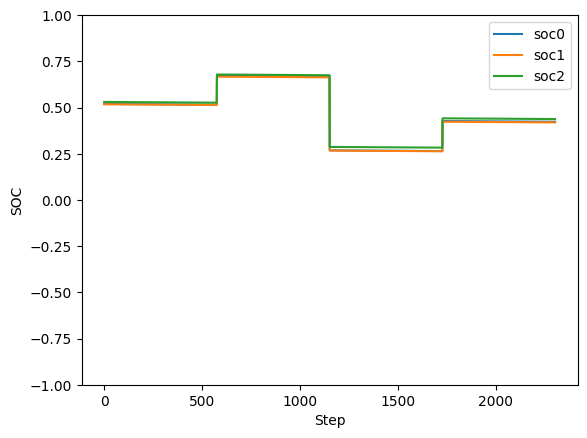

In [8]:
def test_trained_model_no_action():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        # oldObs = obs
        obs, rewards, done, info = model.get_env().step([[-1, -1, -1]])
        episode_reward += rewards.squeeze()

        if not done:
            print(str(obs) + "  ACTION:" + str([-1, -1, -1]) + "  >>>> ")
            print("  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([-1, 1])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            plt.legend()
            #plt.pause(3)

            # obsArray = []
            # episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break




test_trained_model_no_action()